In [1]:
from databaseconnection import DatabaseConnection
gds = DatabaseConnection().get_database_connection()
gds.version()

'2.3.2'

In [6]:
graph_name = 'respondentQuestionAlternativeOnlyStudents'

if gds.graph.exists(graph_name).any():
    gds.graph.drop(gds.graph.get(graph_name))

G, result = gds.graph.project(
    graph_name,
    {
        "Student": {},
        "QuestionAlternative": { "properties": { "position": { "defaultValue": 0 }}}
    },
    "CHOSE_ALT"
)

print(f"The projection took {result['projectMillis']} ms")
print(f"Graph '{G.name()}' node count: {G.node_count()}")
print(f"Graph '{G.name()}' node labels: {G.node_labels()}")

The projection took 37 ms
Graph 'respondentQuestionAlternativeOnlyStudents' node count: 4574
Graph 'respondentQuestionAlternativeOnlyStudents' node labels: ['Student', 'QuestionAlternative']


## FastRP

In [7]:
result = gds.fastRP.mutate(
    G,
    mutateProperty='embedding',
    randomSeed=42,
    embeddingDimension=128,
    iterationWeights=[0.8, 1, 1, 1, 1]
)
print(f"Number of embedding vectors produced: {result['nodePropertiesWritten']}")

Number of embedding vectors produced: 4574


## Similarity

In [7]:
result = gds.nodeSimilarity.stream(
    G
)
print(result)
print(min(result['similarity']))

        node1   node2  similarity
0        7483    9242    0.573333
1        7483   11162    0.526316
2        7483   11351    0.474359
3        7483   11225    0.474359
4        7483   12044    0.463415
...       ...     ...         ...
30295  218576  192378    0.321839
30296  218576  211766    0.311111
30297  218576   44756    0.309278
30298  218576  220378    0.303371
30299  218576  163083    0.303371

[30300 rows x 3 columns]
0.02127659574468085


In [8]:
gds.nodeSimilarity.write(
    G,
    writeRelationshipType='NODESIMILARITY_POS_PROP',
    writeProperty='similarity',
)

NodeSimilarity:   0%|          | 0/100 [00:00<?, ?%/s]

preProcessingMillis                                                       0
computeMillis                                                          1066
writeMillis                                                             342
postProcessingMillis                                                     -1
nodesCompared                                                          3030
relationshipsWritten                                                  30300
similarityDistribution    {'p1': 0.22680461406707764, 'max': 1.000007510...
configuration             {'topK': 10, 'writeConcurrency': 4, 'similarit...
Name: 0, dtype: object

In [9]:
gds.run_cypher("""
MATCH p=()-[r:NODESIMILARITY_POS_PROP]->() RETURN r.similarity ORDER BY r.similarity DESC;
""")

,r.similarity
0,1.000000
1,1.000000
2,1.000000
3,1.000000
4,1.000000
...,...
30295,0.035714
30296,0.031250
30297,0.024390
30298,0.021739


In [8]:
result = gds.knn.stream(
    G,
    topK=2,
    nodeProperties=["embedding"],
    randomSeed=42,
    concurrency=1,
    sampleRate=1.0,
    deltaThreshold=0.0,
    # writeRelationshipType="SIMILAR_STUDENTS",
    # writeProperty="score",
)
print(result)

       node1   node2  similarity
0       6965  178588    0.000000
1       6965  214529    0.000000
2       6966    7749    0.000000
3       6966    7703    0.000000
4       6967   94943    0.000000
...      ...     ...         ...
9143  163788  108564    0.774274
9144  163852  124833    0.782851
9145  163852   61316    0.772491
9146  163917  121265    0.783764
9147  163917   33718    0.776819

[9148 rows x 3 columns]


In [21]:
result = gds.knn.write(
    G,
    topK=2,
    nodeProperties=["embedding"],
    randomSeed=42,
    concurrency=1,
    sampleRate=1.0,
    deltaThreshold=0.0,
    writeRelationshipType="KNN_SIMILARITY_POS_PROP",
    writeProperty="score",
)

print(f"Relationships produced: {result['relationshipsWritten']}")
print(f"Nodes compared: {result['nodesCompared']}")
print(f"Mean similarity: {result['similarityDistribution']['mean']}")

Knn:   0%|          | 0/100 [00:00<?, ?%/s]

Relationships produced: 9148
Nodes compared: 4574
Mean similarity: 0.5562124148069848


In [28]:
gds.run_cypher("""
MATCH (s1:Student)-[r1:KNN_SIMILARITY_POS_PROP]->(s2:Student), (s1)-[r2:NODESIMILARITY_POS_PROP]->(s2)
WHERE id(s1) < id(s2)
RETURN id(s1), id(s2), r1.score AS knnSimilarity, r2.similarity AS nodeSimilarity, ((r1.score + r2.similarity) / 2) AS meanSimilarity, abs(r1.score - r2.similarity) AS difference
ORDER BY difference ASC
""")

,id(s1),id(s2),knnSimilarity,nodeSimilarity,meanSimilarity,difference
0,20279,76211,1.000000,1.000000,1.000000,0.000000
1,105596,157966,1.000000,1.000000,1.000000,0.000000
2,127471,173468,1.000000,1.000000,1.000000,0.000000
3,105596,153944,0.989694,0.965517,0.977605,0.024176
4,153944,157966,0.989694,0.965517,0.977605,0.024176
...,...,...,...,...,...,...
1522,135928,144022,0.788712,0.255814,0.522263,0.532898
1523,147685,209454,0.773974,0.239583,0.506779,0.534391
1524,95195,166278,0.785277,0.250000,0.517638,0.535277
1525,20279,180514,0.745425,0.166667,0.456046,0.578758


In [14]:
result = gds.run_cypher("""
MATCH (s1:Student)-[r1:NODESIMILARITY_POS_PROP]->(s2:Student)
WHERE id(s1) < id(s2)
RETURN id(s1), id(s2), r1.similarity AS nodeSimilarity
""")
print("Mean Node similarity: ", result["nodeSimilarity"].mean())
print("Max Node similarity: ", result["nodeSimilarity"].max())
# print("Min Node similarity: ", result["nodeSimilarity"].min())
# print("Nr of 0.0 Node similarities: ", result["nodeSimilarity"].value_counts()[0.0])
print("Nr of 1.0 Node similarities: ", result["nodeSimilarity"].value_counts()[1.0])

Mean Node similarity:  0.48627717800963927
Max Node similarity:  1.0
Nr of 1.0 Node similarities:  6


## PLOTTING
Tänk på att kNN även har utvärderat likheten mellan Student och QuestionAlternative. Anledning till att den är förskjuten.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = gds.run_cypher("""
MATCH (s1:Student)-[r1:KNN_SIMILARITY_POS_PROP]->(s2:Student), (s1)-[r2:NODESIMILARITY_POS_PROP]->(s2)
WHERE id(s1) < id(s2)
RETURN id(s1), id(s2), r1.score AS knnSimilarity, r2.similarity AS nodeSimilarity, ((r1.score + r2.similarity) / 2) AS meanSimilarity, abs(r1.score - r2.similarity) AS difference
ORDER BY difference ASC
""")

sim_scores_knn = data['knnSimilarity']
sim_scores_node = data['nodeSimilarity']

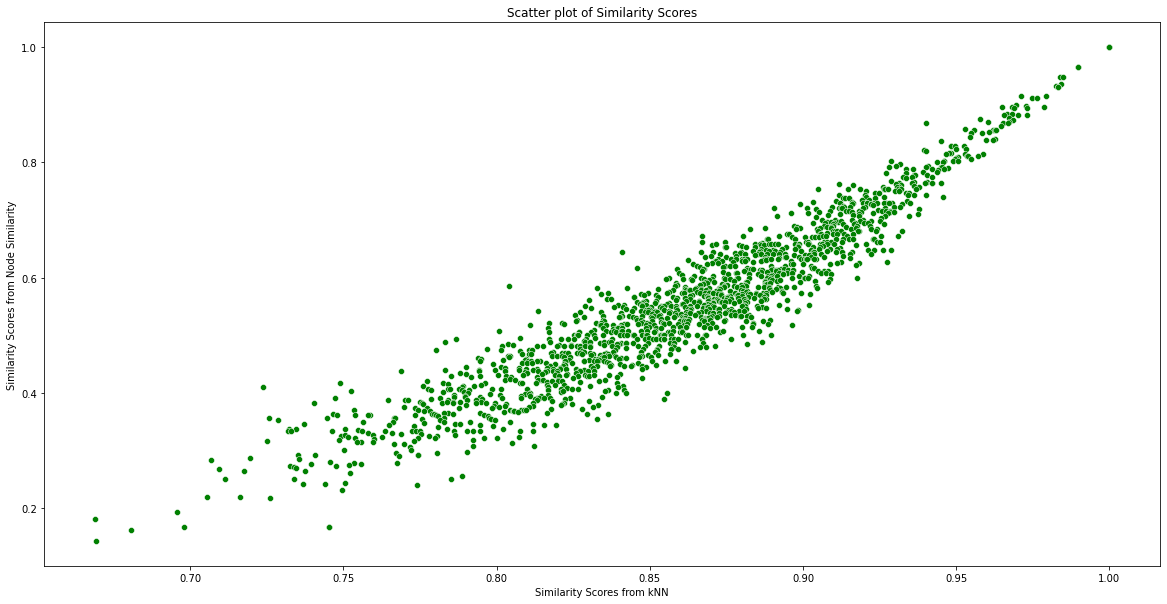

In [20]:
# Scatter plot
plt.figure(figsize=(20, 10))
sns.scatterplot(x=sim_scores_knn, y=sim_scores_node, color='green')
plt.xlabel('Similarity Scores from kNN')
plt.ylabel('Similarity Scores from Node Similarity')
plt.title('Scatter plot of Similarity Scores')
plt.show()

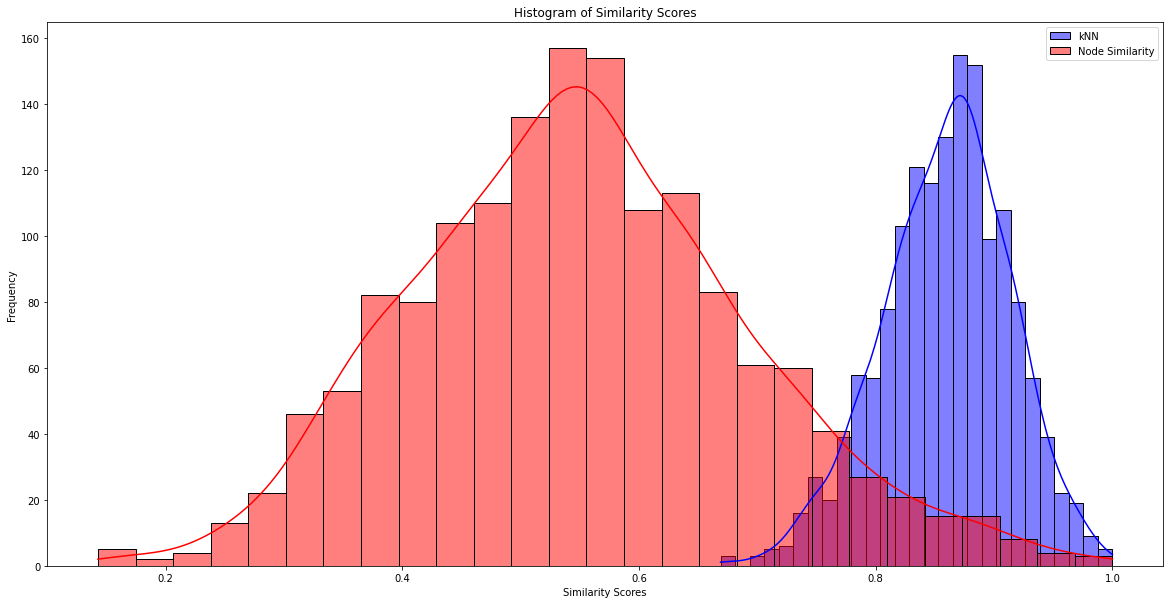

In [6]:
# Histograms
plt.figure(figsize=(20, 10))
sns.histplot(sim_scores_knn, color='blue', alpha=0.5, label='kNN', kde=True)
sns.histplot(sim_scores_node, color='red', alpha=0.5, label='Node Similarity', kde=True)
plt.xlabel('Similarity Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Similarity Scores')
plt.legend()
plt.show()

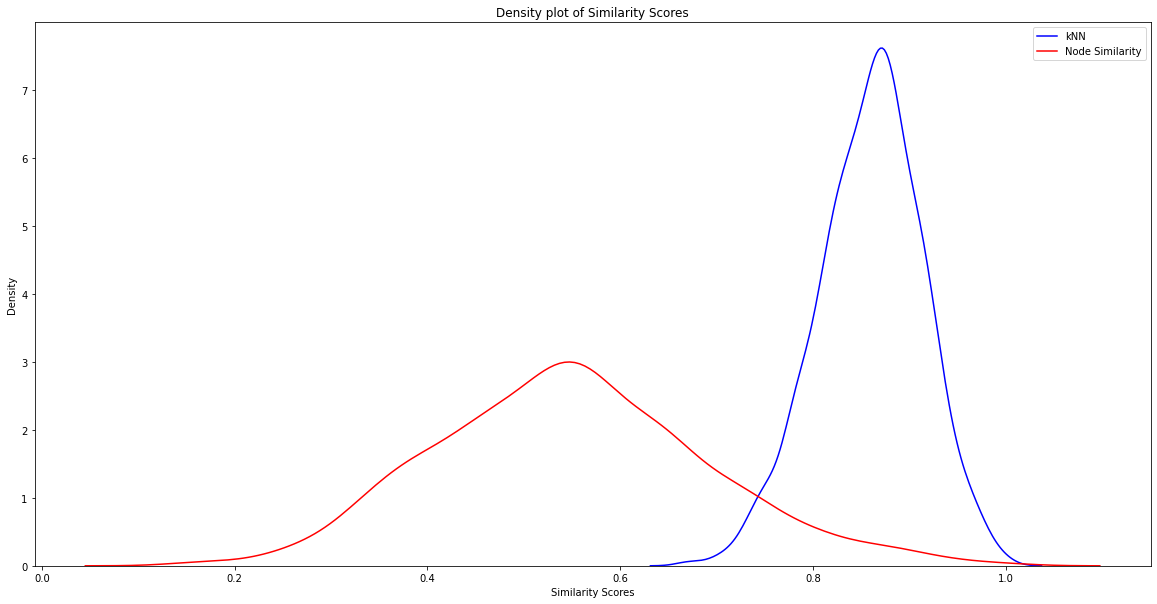

In [7]:
# Density plot
plt.figure(figsize=(20, 10))
sns.kdeplot(sim_scores_knn, color='blue', label='kNN')
sns.kdeplot(sim_scores_node, color='red', label='Node Similarity')
plt.xlabel('Similarity Scores')
plt.ylabel('Density')
plt.title('Density plot of Similarity Scores')
plt.legend()
plt.show()


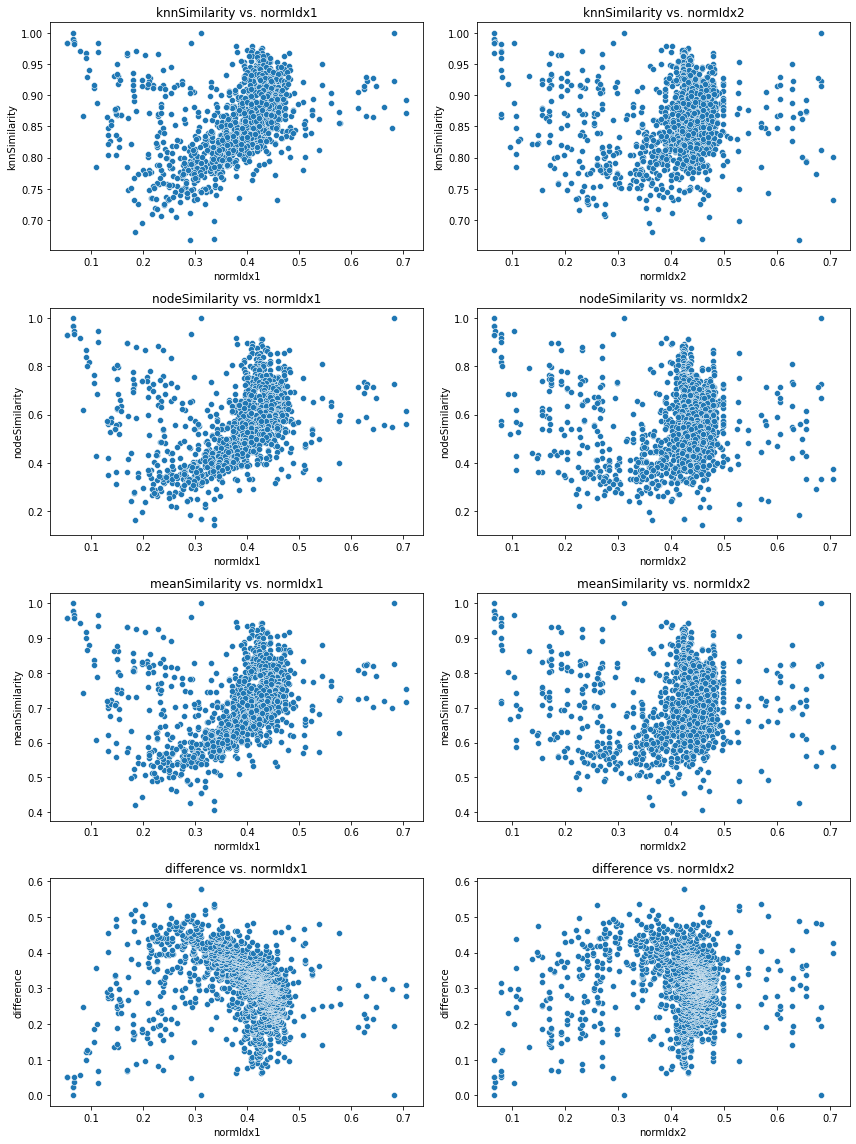

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = gds.run_cypher("""
MATCH (s1:Student)-[r1:KNN_SIMILARITY_POS_PROP]->(s2:Student), (s1)-[r2:NODESIMILARITY_POS_PROP]->(s2)
WHERE id(s1) < id(s2)
RETURN id(s1), s1.normalityIndex AS normIdx1, id(s2), s2.normalityIndex AS normIdx2, r1.score AS knnSimilarity, r2.similarity AS nodeSimilarity, ((r1.score + r2.similarity) / 2) AS meanSimilarity, abs(r1.score - r2.similarity) AS difference
ORDER BY difference ASC
""")


df = pd.DataFrame(data)

# Scatter plots
fig, axes = plt.subplots(4, 2, figsize=(12, 16))

features = ['knnSimilarity', 'nodeSimilarity', 'meanSimilarity', 'difference']

for i, feature in enumerate(features):
    sns.scatterplot(ax=axes[i, 0], data=df, x='normIdx1', y=feature)
    axes[i, 0].set_title(f'{feature} vs. normIdx1')

    sns.scatterplot(ax=axes[i, 1], data=df, x='normIdx2', y=feature)
    axes[i, 1].set_title(f'{feature} vs. normIdx2')

plt.tight_layout()
plt.show()

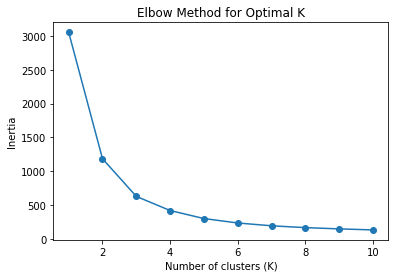

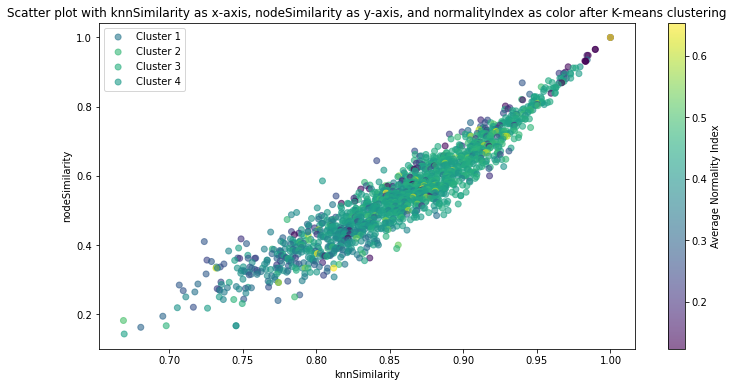

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


df = pd.DataFrame(data)
df['avgNormalityIndex'] = (df['normIdx1'] + df['normIdx2']) / 2

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['knnSimilarity', 'nodeSimilarity']])

# Elbow method
inertia = []
k_values = list(range(1, 11))

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# You can choose the optimal K by identifying the "elbow" point in the graph
optimal_k = 4  # Replace 3 with the value you observe from the graph

# Apply K-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Create a scatter plot with knnSimilarity as the x-axis, nodeSimilarity as the y-axis, normalityIndex as color, and cluster labels as markers
plt.figure(figsize=(12, 6))

for cluster in range(optimal_k):
    plt.scatter(
        x=df.loc[clusters == cluster, 'knnSimilarity'],
        y=df.loc[clusters == cluster, 'nodeSimilarity'],
        c=df.loc[clusters == cluster, 'avgNormalityIndex'],
        cmap='viridis',
        alpha=0.6,
        label=f'Cluster {cluster + 1}'
    )

# Customize plot appearance
plt.xlabel('knnSimilarity')
plt.ylabel('nodeSimilarity')
plt.title('Scatter plot with knnSimilarity as x-axis, nodeSimilarity as y-axis, and normalityIndex as color after K-means clustering')
plt.legend()
plt.colorbar(label='Average Normality Index')

plt.show()